In [44]:
%run init.ipynb

In [45]:
from qiskit import *

### Notas de aula de Computação Quântica <br> Autor: Jonas Maziero

# Troca de estados quânticos

## Matriz densidade de 2 qubits

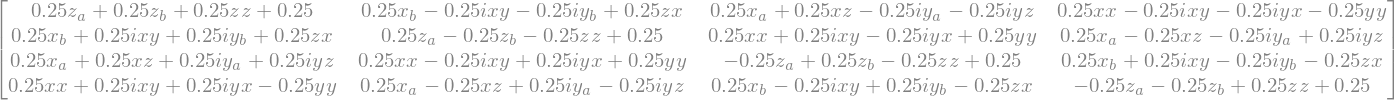

In [15]:
X = Matrix([[0,1],[1,0]]); Y = Matrix([[0,-1j],[1j,0]]); Z = Matrix([[1,0],[0,-1]]); I = Matrix([[1,0],[0,1]])
xa,ya,za,xb,yb,zb = symbols('x_a y_a z_a x_b y_b z_b')
xx,xy,xz,yx,yy,yz,zx,zy,zz = symbols('xx xy xz yx yy yz zx zy zz')
rho_ab = (1/4)*(tp(I,I) + xa*tp(X,I) + ya*tp(Y,I) + za*tp(Z,I) + xb*tp(I,X) + yb*tp(I,Y) + zb*tp(I,Z))
rho_ab += (1/4)*(xx*tp(X,X) + xy*tp(X,Y) + xz*tp(X,Z) + yx*tp(Y,X) + yy*tp(Y,Y) + yz*tp(Y,Z))
rho_ab += (1/4)*(zx*tp(Z,X) + xy*tp(Z,Y) + zz*tp(Z,Z))
rho_ab

In [16]:
trace(rho_ab)

## Traço, traço parcial e matriz densidade reduzida
O traço de uma matriz é a soma dos elementos em sua diagonal principal
\begin{equation}
Tr(A) = \sum_{j}A_{j,j} = \sum_{j}\langle \Psi_{j}|A|\Psi_{j}\rangle,
\end{equation}
com $\{\Psi_{j}\}$ sendo uma base qualquer do espaço onde a matriz $A$ está definida.

A função traço parcial é definida por
\begin{align}
& \rho_{a} = Tr_{b}(\rho_{ab})= \sum_{j=1}^{d_{b}}(I\otimes\langle b_{j}|)\rho_{ab}(I\otimes|b_{j}\rangle), \\
& \rho_{b} = \sum_{j=1}^{d_{a}}(\langle a_{j}|\otimes I)\rho_{ab}(|a_{j}\rangle\otimes I).
\end{align}

In [6]:
def ptraceA(da, db, rho):
    rhoB = zeros(db,db)
    for j in range(0, db):
        for k in range(0, db):
            for l in range(0, da):
                rhoB[j,k] += rho[l*db+j,l*db+k]
    return rhoB
def ptraceB(da, db, rho):
    rhoA = zeros(da,da)
    for j in range(0, da):
        for k in range(0, da):
            for l in range(0, db):
                rhoA[j,k] += rho[j*db+l,k*db+l]
    return rhoA

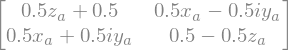

In [19]:
rho_a = ptraceB(2, 2, rho_ab); rho_a

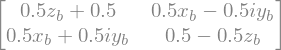

In [20]:
rho_b = ptraceA(2, 2, rho_ab); rho_b

Ou seja
\begin{align}
& \rho_{a} = \frac{1}{2}\big(I+x_{a}X+y_{a}Y+z_{a}Z\big), \\
& \rho_{b} = \frac{1}{2}\big(I+x_{b}X+y_{b}Y+z_{b}Z\big).
\end{align}

## Aplicando a SWAP

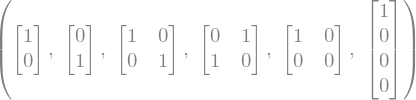

In [25]:
# alguns resultados prontos que usare de init.ipynb
cb(2,0), cb(2,1), id(2), pauli(1), proj(cb(2,0)), tp(cb(2,0),cb(2,0))

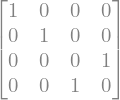

In [21]:
CX_ab = tp(proj(cb(2,0)),id(2)) + tp(proj(cb(2,1)),pauli(1)); CX_ab

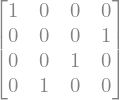

In [22]:
CX_ba = tp(id(2),proj(cb(2,0))) + tp(pauli(1),proj(cb(2,1))); CX_ba

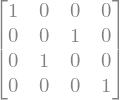

In [31]:
SWAP = CX_ab*CX_ba*CX_ab; SWAP

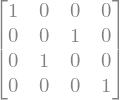

In [32]:
SWAP = CX_ba*CX_ab*CX_ba; SWAP

$$\rho_{ab}^{swap} = (SWAP)\rho_{ab}(SWAP)^{\dagger}$$

In [33]:
# aplica a troca ao estado de 2 qubits
rho_ab_swap = SWAP*rho_ab*SWAP # pois a SWAP é hermitiana

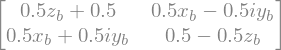

In [34]:
# verificação que a troca ocorreu
rho_a_swap = ptraceB(2, 2, rho_ab_swap); rho_a_swap

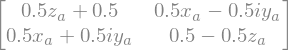

In [35]:
rho_b_swap = ptraceA(2, 2, rho_ab_swap); rho_b_swap

Ou seja
$$\rho_{a}^{swap}=\rho_{b} \text{ e } \rho_{b}^{swap}=\rho_{a}.$$

### Traço parcial calculado numericamente
Precisaremos dessas funções para os dados obtidos dos experimentos e simulações.

In [55]:
def pTraceL_num(dl, dr, rhoLR):
    # Returns the left partial trace over the 'left' subsystem of rhoLR
    rhoR = np.zeros((dr, dr), dtype=complex)
    for j in range(0, dr):
        for k in range(j, dr):
            for l in range(0, dl):
                rhoR[j,k] += rhoLR[l*dr+j,l*dr+k]
            if j != k:
                rhoR[k,j] = np.conj(rhoR[j,k])
    return rhoR


def pTraceR_num(dl, dr, rhoLR):
    # Returns the right partial trace over the 'right' subsystem of rhoLR
    rhoL = np.zeros((dl, dl), dtype=complex)
    for j in range(0, dl):
        for k in range(j, dl):
            for l in range(0, dr):
                rhoL[j,k] += rhoLR[j*dr+l,k*dr+l]
        if j != k:
            rhoL[k,j] = np.conj(rhoL[j,k])
    return rhoL

## Simulação e implementação experimental da troca de estados

Vamos considerar 
\begin{align}
& \rho_{a} = |0\rangle\langle 0| = \begin{bmatrix}1&0\\0&0 \end{bmatrix}, \\
& \rho_{b} = |\oplus\rangle\langle \oplus| = \begin{bmatrix}1/2&-i/2\\i/2&1/2 \end{bmatrix}.
\end{align}

### Simulação

In [50]:
qr = QuantumRegister(2); qc = QuantumCircuit(qr)

#### Preparação dos estados

In [51]:
qc.h(qr[1]); qc.s(qr[1]); qc.draw()

q1_0: ──────────
      ┌───┐┌───┐
q1_1: ┤ H ├┤ S ├
      └───┘└───┘

##### Para a TEQ do circuito acima

In [53]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
nshots = 8192
qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # circuito para TEQ
job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots) # executa no simulador
qstf = StateTomographyFitter(job.result(), qstc) # ajusta os dados
rhoBA = qstf.fit(method='lstsq'); rhoBA # extrai o operador densidade

array([[ 5.00280446e-01+0.00000000e+00j, -3.70362278e-03-4.21296259e-04j,
         5.52106670e-03-4.98425746e-01j, -1.59591063e-03+1.63496300e-03j],
       [-3.70362278e-03+4.21296259e-04j,  5.37412125e-04+0.00000000e+00j,
         1.38224356e-03+3.85082021e-03j,  1.14618881e-05-5.22998440e-04j],
       [ 5.52106670e-03+4.98425746e-01j,  1.38224356e-03-3.85082021e-03j,
         4.98662244e-01+0.00000000e+00j, -1.80074933e-03-2.57547291e-03j],
       [-1.59591063e-03-1.63496300e-03j,  1.14618881e-05+5.22998440e-04j,
        -1.80074933e-03+2.57547291e-03j,  5.19898627e-04+0.00000000e+00j]])

Aqui aparece a questão da ordem trocada dos qubits ($\rho\equiv\rho_{BA}$)

In [56]:
rhoA = pTraceL_num(2, 2, rhoBA); rhoA

array([[ 0.99894269+0.j        , -0.00550437-0.00299677j],
       [-0.00550437+0.00299677j,  0.00105731+0.j        ]])

In [57]:
rhoB = pTraceR_num(2, 2, rhoBA); rhoB

array([[0.50081786+0.j        , 0.00553253-0.49894874j],
       [0.00553253+0.49894874j, 0.49918214+0.j        ]])

#### Fazendo o swap dos estados

In [59]:
qc.cx(qr[0],qr[1]); qc.cx(qr[0],qr[1]); qc.draw()

q1_0: ────────────■────■────■────■──
      ┌───┐┌───┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐
q1_1: ┤ H ├┤ S ├┤ X ├┤ X ├┤ X ├┤ X ├
      └───┘└───┘└───┘└───┘└───┘└───┘

##### Retirando uma porta lógica (errada) do circuito
Dá pra fazer isso iniciando o circuito do zero ou usando os comandos a seguir.

In [60]:
# data contém todas as portas lógicas do cicuito quântico em uma lista (ou dicionário)
data = qc.data; data

[(<qiskit.circuit.library.standard_gates.h.HGate object at 0x7f7d57c84dc0>, [Qubit(QuantumRegister(2, 'q1'), 1)], []), (<qiskit.circuit.library.standard_gates.s.SGate object at 0x7f7d57c84fa0>, [Qubit(QuantumRegister(2, 'q1'), 1)], []), (<qiskit.circuit.library.standard_gates.x.CXGate object at 0x7f7d5437de50>, [Qubit(QuantumRegister(2, 'q1'), 0), Qubit(QuantumRegister(2, 'q1'), 1)], []), (<qiskit.circuit.library.standard_gates.x.CXGate object at 0x7f7d5437ddf0>, [Qubit(QuantumRegister(2, 'q1'), 0), Qubit(QuantumRegister(2, 'q1'), 1)], []), (<qiskit.circuit.library.standard_gates.x.CXGate object at 0x7f7d57c84670>, [Qubit(QuantumRegister(2, 'q1'), 0), Qubit(QuantumRegister(2, 'q1'), 1)], []), (<qiskit.circuit.library.standard_gates.x.CXGate object at 0x7f7d54360bb0>, [Qubit(QuantumRegister(2, 'q1'), 0), Qubit(QuantumRegister(2, 'q1'), 1)], [])]

In [61]:
# imprime uma componente de qc.data
print( data[3] )

(<qiskit.circuit.library.standard_gates.x.CXGate object at 0x7f7d5437ddf0>, [Qubit(QuantumRegister(2, 'q1'), 0), Qubit(QuantumRegister(2, 'q1'), 1)], [])


In [62]:
# deleta uma componente de data
data.pop(3)

(<qiskit.circuit.library.standard_gates.x.CXGate at 0x7f7d5437ddf0>,
 [Qubit(QuantumRegister(2, 'q1'), 0), Qubit(QuantumRegister(2, 'q1'), 1)],
 [])

In [63]:
data.pop(4)

(<qiskit.circuit.library.standard_gates.x.CXGate at 0x7f7d54360bb0>,
 [Qubit(QuantumRegister(2, 'q1'), 0), Qubit(QuantumRegister(2, 'q1'), 1)],
 [])

In [65]:
data.pop(3)

(<qiskit.circuit.library.standard_gates.x.CXGate at 0x7f7d57c84670>,
 [Qubit(QuantumRegister(2, 'q1'), 0), Qubit(QuantumRegister(2, 'q1'), 1)],
 [])

In [66]:
# agora o circuit está como queremos
qc.draw()

q1_0: ────────────■──
      ┌───┐┌───┐┌─┴─┐
q1_1: ┤ H ├┤ S ├┤ X ├
      └───┘└───┘└───┘

#### Voltando ao swap dos estados

In [71]:
qc.cx(qr[1],qr[0]); qc.draw()

┌───┐┌───┐
q1_0: ────────────■──┤ X ├┤ X ├
      ┌───┐┌───┐┌─┴─┐└─┬─┘└─┬─┘
q1_1: ┤ H ├┤ S ├┤ X ├──■────■──
      └───┘└───┘└───┘

In [72]:
data = qc.data; data.pop(3)

(<qiskit.circuit.library.standard_gates.x.CXGate at 0x7f7d54367430>,
 [Qubit(QuantumRegister(2, 'q1'), 1), Qubit(QuantumRegister(2, 'q1'), 0)],
 [])

In [73]:
qc.cx(qr[0],qr[1]); qc.draw()

┌───┐     
q1_0: ────────────■──┤ X ├──■──
      ┌───┐┌───┐┌─┴─┐└─┬─┘┌─┴─┐
q1_1: ┤ H ├┤ S ├┤ X ├──■──┤ X ├
      └───┘└───┘└───┘     └───┘

In [74]:
qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # circuito para TEQ
job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots) # executa no simulador
qstf = StateTomographyFitter(job.result(), qstc) # ajusta os dados
rhoBA = qstf.fit(method='lstsq'); # extrai o operador densidade

In [75]:
rhoA = pTraceL_num(2, 2, rhoBA); rhoA

array([[ 0.49951394+0.j        , -0.00188106-0.49904599j],
       [-0.00188106+0.49904599j,  0.50048606+0.j        ]])

In [76]:
rhoB = pTraceR_num(2, 2, rhoBA); rhoB

array([[ 9.99011909e-01+0.j        , -6.98091086e-03-0.00010763j],
       [-6.98091086e-03+0.00010763j,  9.88091258e-04+0.j        ]])

### Experimento

##### Preparação dos estados

In [152]:
qr = QuantumRegister(2); qc = QuantumCircuit(qr)
qc.h(qr[1]); qc.s(qr[1]); qc.barrier(); qc.draw()

░ 
q16_0: ───────────░─
       ┌───┐┌───┐ ░ 
q16_1: ┤ H ├┤ S ├─░─
       └───┘└───┘ ░

In [81]:
qiskit.IBMQ.load_account();
provider = IBMQ.get_provider(hub = 'ibm-q-research-2', group = 'federal-uni-sant-1', project = 'main')
device = provider.get_backend('ibmq_belem')
from qiskit.tools.monitor import job_monitor

In [82]:
qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # circuito para TEQ
job = qiskit.execute(qstc, backend = device, shots = nshots)
print(job.job_id()); job_monitor(job)

61841ca06e4da211ea9b5b9e
Job Status: job has successfully run


In [83]:
qstf = StateTomographyFitter(job.result(), qstc) # ajusta os dados
rhoBA = qstf.fit(method='lstsq'); # extrai o operador densidade
rhoA = pTraceL_num(2, 2, rhoBA); rhoA

array([[0.99352204+0.j        , 0.02644131-0.06014646j],
       [0.02644131+0.06014646j, 0.00647796+0.j        ]])

In [84]:
rhoB = pTraceR_num(2, 2, rhoBA); rhoB

array([[0.52465211+0.j        , 0.03226595-0.48297778j],
       [0.03226595+0.48297778j, 0.47534789+0.j        ]])

##### Troca dos estados

In [153]:
qc.cx(qr[0],qr[1]); qc.cx(qr[1],qr[0]); qc.cx(qr[0],qr[1]); 

In [150]:
data = qc.data; data.pop(5)

(<qiskit.circuit.library.standard_gates.x.CXGate at 0x7f7d522ad0d0>,
 [Qubit(QuantumRegister(2, 'q15'), 0), Qubit(QuantumRegister(2, 'q15'), 1)],
 [])

In [154]:
qc.draw()

░      ┌───┐     
q16_0: ───────────░───■──┤ X ├──■──
       ┌───┐┌───┐ ░ ┌─┴─┐└─┬─┘┌─┴─┐
q16_1: ┤ H ├┤ S ├─░─┤ X ├──■──┤ X ├
       └───┘└───┘ ░ └───┘     └───┘

In [91]:
qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # circuito para TEQ
job = qiskit.execute(qstc, backend = device, shots = nshots)
print(job.job_id()); job_monitor(job)

61841d516e4da2c4c09b5bad
Job Status: job has successfully run


In [92]:
qstf = StateTomographyFitter(job.result(), qstc) # ajusta os dados
rhoBA = qstf.fit(method='lstsq'); # extrai o operador densidade
rhoA = pTraceL_num(2, 2, rhoBA); rhoA

array([[0.51277093+0.j       , 0.0100801 -0.4409531j],
       [0.0100801 +0.4409531j, 0.48722907+0.j       ]])

In [93]:
rhoB = pTraceR_num(2, 2, rhoBA); rhoB

array([[0.93142851+0.j       , 0.03019276-0.0574553j],
       [0.03019276+0.0574553j, 0.06857149+0.j       ]])

### Exercício 
Simule e execute a troca de estados para o estado de 2 qubits preparado sendo
$$|\Psi\rangle = \cos(\theta/2)\cos(\phi/2)|00\rangle + \cos(\theta/2)\sin(\phi/2)|01\rangle + \sin(\theta/2)\cos(\phi/2)|11\rangle  + \sin(\theta/2)\sin(\phi/2)|10\rangle.$$
Faça o circuito para preparar este estado geral. Para a simulação e execução use 
$$\theta=\pi/3 \text{ e } \phi = \pi/4.$$
As contas abaixo, que usei pra formular este exercício, podem lhe ajudar a preceber como montar o circuito quântico.

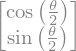

In [29]:
def psi(th):
    return cos(th/2)*cb(2,0) + sin(th/2)*cb(2,1)
th, ph = symbols('theta phi'); psi(th)

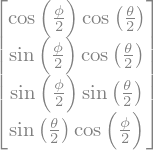

In [31]:
def Psi(th,ph):
    return CX_ab*tp(psi(th),psi(ph))
th, ph = symbols('theta phi'); Psi(th,ph)

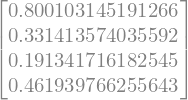

In [32]:
th, ph = math.pi/3, math.pi/4; Psi(th,ph)

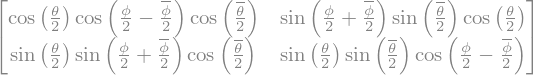

In [33]:
def rhoA(th,ph):
    return ptraceB(2, 2, proj(Psi(th,ph)))
th, ph = symbols('theta phi'); simplify(rhoA(th,ph))

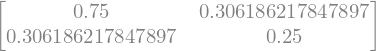

In [34]:
th, ph = math.pi/3, math.pi/4; simplify(rhoA(th,ph))

In [41]:
rhoa = rhoA(th,ph); rhoa.eigenvals()

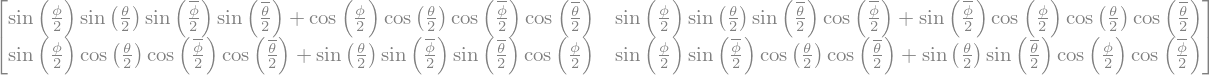

In [35]:
def rhoB(th,ph):
    return ptraceA(2, 2, proj(Psi(th,ph)))
th, ph = symbols('theta phi'); simplify(rhoB(th,ph))

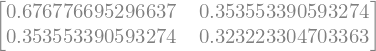

In [36]:
th, ph = math.pi/3, math.pi/4; simplify(rhoB(th,ph))

In [40]:
rhob = rhoB(th,ph); rhob.eigenvals()

#### preparação

In [155]:
qr = QuantumRegister(2); qc = QuantumCircuit(qr)

In [156]:
th = math.pi/3; ph = math.pi/4
qc.u(th,0,0,qr[0]); qc.u(ph,0,0,qr[1]); qc.cx(qr[0],qr[1]); qc.barrier();

In [157]:
qc.draw()

┌────────────┐      ░ 
q17_0: ┤ U(π/3,0,0) ├──■───░─
       ├────────────┤┌─┴─┐ ░ 
q17_1: ┤ U(π/4,0,0) ├┤ X ├─░─
       └────────────┘└───┘ ░

In [118]:
data = qc.data; data.pop(1);

(<qiskit.circuit.library.standard_gates.u.UGate at 0x7f7d5226be80>,
 [Qubit(QuantumRegister(2, 'q9'), 1)],
 [])

##### simulação

In [130]:
qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # circuito para TEQ
job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots) # executa no simulador
qstf = StateTomographyFitter(job.result(), qstc) # ajusta os dados
rhoBA = qstf.fit(method='lstsq'); # extrai o operador densidade

In [131]:
rhoA = pTraceL_num(2, 2, rhoBA); rhoA

array([[0.74863109+0.j        , 0.30284415-0.00066973j],
       [0.30284415+0.00066973j, 0.25136891+0.j        ]])

In [132]:
rhoB = pTraceR_num(2, 2, rhoBA); rhoB

array([[0.67607346+0.j        , 0.34993063+0.00195568j],
       [0.34993063-0.00195568j, 0.32392654+0.j        ]])

##### experimento

In [133]:
qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # circuito para TEQ
job = qiskit.execute(qstc, backend = device, shots = nshots)
print(job.job_id()); job_monitor(job)

6184249ba248d57c6890d805
Job Status: job has successfully run


In [159]:
rhoA = pTraceL_num(2, 2, rhoBA); rhoA

array([[0.74863109+0.j        , 0.30284415-0.00066973j],
       [0.30284415+0.00066973j, 0.25136891+0.j        ]])

In [160]:
rhoB = pTraceR_num(2, 2, rhoBA); rhoB

array([[0.67607346+0.j        , 0.34993063+0.00195568j],
       [0.34993063-0.00195568j, 0.32392654+0.j        ]])

#### troca de estados

In [158]:
qc.cx(qr[1],qr[0]); qc.cx(qr[0],qr[1]); qc.cx(qr[1],qr[0])
qc.draw()

┌────────────┐      ░ ┌───┐     ┌───┐
q17_0: ┤ U(π/3,0,0) ├──■───░─┤ X ├──■──┤ X ├
       ├────────────┤┌─┴─┐ ░ └─┬─┘┌─┴─┐└─┬─┘
q17_1: ┤ U(π/4,0,0) ├┤ X ├─░───■──┤ X ├──■──
       └────────────┘└───┘ ░      └───┘

#### simulação

In [161]:
qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # circuito para TEQ
job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots) # executa no simulador
qstf = StateTomographyFitter(job.result(), qstc) # ajusta os dados
rhoBA = qstf.fit(method='lstsq'); # extrai o operador densidade

In [162]:
rhoA = pTraceL_num(2, 2, rhoBA); rhoA

array([[0.67552911+0.j        , 0.35113749+0.00340661j],
       [0.35113749-0.00340661j, 0.32447089+0.j        ]])

In [163]:
rhoB = pTraceR_num(2, 2, rhoBA); rhoB

array([[0.7480852 +0.j        , 0.30240235-0.00110915j],
       [0.30240235+0.00110915j, 0.2519148 +0.j        ]])

##### experimento

In [164]:
qstc = state_tomography_circuits(qc, [qr[0],qr[1]]); # circuito para TEQ
job = qiskit.execute(qstc, backend = device, shots = nshots)
print(job.job_id()); job_monitor(job)

61842631d0f1dd2c89e9ce3b
Job Status: job has successfully run


In [165]:
rhoA = pTraceL_num(2, 2, rhoBA); rhoA

array([[0.67552911+0.j        , 0.35113749+0.00340661j],
       [0.35113749-0.00340661j, 0.32447089+0.j        ]])

In [166]:
rhoB = pTraceR_num(2, 2, rhoBA); rhoB

array([[0.7480852 +0.j        , 0.30240235-0.00110915j],
       [0.30240235+0.00110915j, 0.2519148 +0.j        ]])